# 2016 SEG ML Contest entry by Alan Richardson (Ausar Geophysical)

This notebook discusses some of the ideas contained in my submission. The majority of the code in my submission is in the [`ar4_submission3.py`](https://github.com/seg/2016-ml-contest/blob/master/ar4/ar4_submission3.py) script.

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import scipy.interpolate

from ar4_submission3 import run, get_numwells, get_wellnames

run_ml = False # run the ML estimators, if false just loads results from file
solve_rgt = False # run the RGT solver - takes about 30mins, run_ml must be True

if run_ml:
    data = run_all(solve_rgt)
else:
    data = pd.read_csv('ar4_submission3.csv')

In [7]:
matplotlib.style.use('ggplot')
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')

def plotwellsim(data,f,y=None,title=None):
    wells = data['Well Name'].unique()
    nwells = len(wells)
    dfg = data.groupby('Well Name',sort=False)
    fig, ax = plt.subplots(nrows=1, ncols=nwells, figsize=(12, 9), sharey=True)
    if (title):
        plt.suptitle(title)
    if (y):
        miny = data[y].min()
        maxy = data[y].max()
        ax[0].set_ylabel(y)
    else:
        miny = 0
        maxy = dfg.size().max()
        ax[0].set_ylabel('Depth from top of well')
    vmin=data[f].min()
    vmax=data[f].max()
    if (f=='Facies') | (f=='NeighbFacies'):
        cmap = cmap_facies
    else:
        cmap = 'viridis'
    for wellidx,(name,group) in enumerate(dfg):
        if y:
            welldinterp = scipy.interpolate.interp1d(group[y], group[f], bounds_error=False)
            nf = len(data[y].unique())
        else:
            welldinterp = scipy.interpolate.interp1d(np.arange(0,len(group[f])), group[f], bounds_error=False)
            nf = (maxy-miny)/0.5
        fnew = np.linspace(miny, maxy, nf) 
        ynew = welldinterp(fnew)
        ynew = ynew[:, np.newaxis]
        ax[wellidx].set_xticks([])
        ax[wellidx].set_yticks([])
        ax[wellidx].grid(False)
        ax[wellidx].imshow(ynew, aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap)
        ax[wellidx].set_xlabel(name,rotation='vertical')

## Introduction

Many contestants have experimented with different estimators. At the time of writing, ensemble tree methods are clearly dominating the top of the leaderboard. This is likely to be because they are (reportedly) less likely to suffer from overfitting than other approaches. As the training set is small, and at least one of the validation wells shows notable differences compared to the training wells (discussed below), overfitting the training dataset is likely to be severely detrimental to validation performance.

Some feature engineering has also proved useful to other entrants. The most successful entries are currently (at the time of writing) all based on the submission 2 of Paolo Bestagini. One of the notable features of Paolo's submission is that it not does contain very sophisticated feature engineering: primarily a simple augmentation of each sample's features by those of the sample above and below in depth. Other entrants, such as Bird Team and geoLEARN, have invested great effort into developing new features, but it has currently not been as successful as Paolo's simple approach. This is again likely to be due to detailed feature sets causing overfitting.

My submission thus only considers ensemble tree estimators. Although a significant number of new features are created through feature engineering, I remained conscious of the risk of overfitting and attempted to mitigate this by using cautious estimator parameters.

## Feature engineering

One of the features provided with the data is the depth (probably height above sea level) at which each sample was measured. This information is discarded by many contestants, as in its current form it does not contain much predictive value. This is due to the differing amounts of uplift at each well causing formations to be at different depths in different wells. This is demonstrated in the figure below. This figure also shows that one of the validation wells (Crawford) has experienced more uplift than any of the training wells. This indicates that it may not be close to the training wells, and so they may not be good predictors of this validation well.

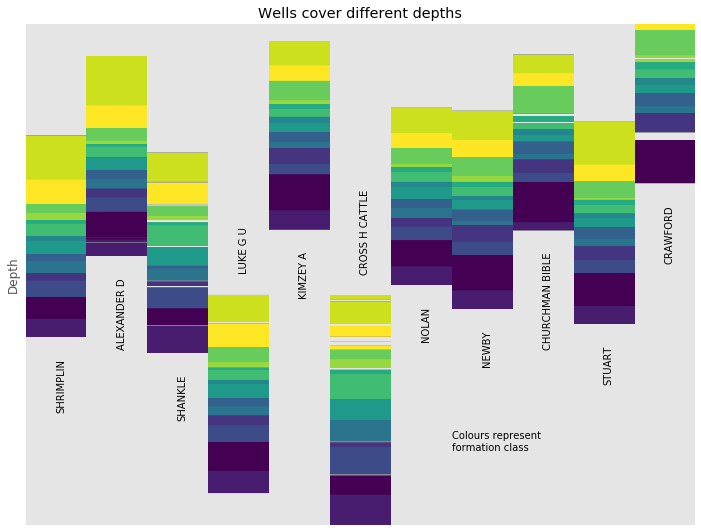

In [8]:
well_width = 100
mind = data['Depth'].min()
maxd = data['Depth'].max()
fim = np.nan*np.ones([int((maxd-mind)*2)+1,get_numwells(data)*well_width])
dfg = data.groupby('Well Name',sort=False)
plt.figure(figsize=(12, 9))
plt.title('Wells cover different depths')
ax=plt.subplot(111)
ax.grid(False)
ax.get_xaxis().set_visible(False)
ax.set_ylabel('Depth')
plt.tick_params(axis="both", which="both", bottom="off", top="off", 
                labelbottom="off", left="off", right="off", labelleft="off")
ax.text(well_width*7,1000,'Colours represent\nformation class')
for i,(name,group) in enumerate(dfg):
    if (maxd-group['Depth'].max())*2 > 600:
        ty = (maxd-group['Depth'].max())*2-50
        tva='bottom'
    else:
        ty = (maxd-group['Depth'].min())*2+50
        tva='top'
    ax.text(well_width*(i+0.5),ty,name,va=tva,rotation='vertical')
    for j in range(len(group)):
        fim[-int((group.loc[group.index[j],'Depth']-maxd)*2),i*well_width:(i+1)*well_width]=group.loc[group.index[j],'FormationClass']
    
plt.imshow(fim,cmap='viridis',aspect='auto')

The figure also demonstrates that most of the wells follow a somewhat consistent pattern with depth in the well. One new feature that I create is thus the depth below the surface, by subtracting the surface depth from the depth measurement at each sample. This creates a feature that captures the element of consistency between the wells with depth below the surface.

One important feature that was not provided with the data is the location of each well. It is plausible that this feature would have some predictive power, as nearby wells are more likely to be similar. The amount of uplift may be an indicator for location, if we assume that the formations can be approximated as being planar. I performed inversions to find 1D and 2D positions for each well using this idea to extract this information, but in the end decided to simply create a feature for each well containing the top depth of the third formation from the surface (the first that is present in all wells without interference from the top of the well)).


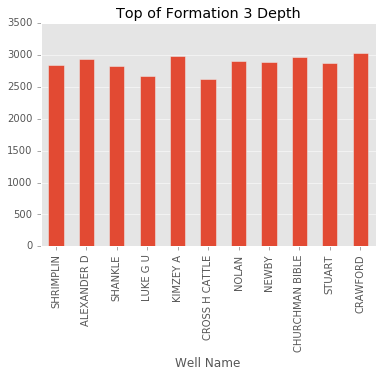

In [9]:
ax=data.groupby('Well Name',sort=False)['Formation3Depth'].first().plot.bar(title='Top of Formation 3 Depth')
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.grid(axis='x')

The wells are too far apart to allow matching of facies between wells. It is thus not possible to build a 3D lithofacies model with which one could interpolate facies in wells without core samples. Nevertheless, one can still try to extract some information by matching wells. To achieve this, I use an approach similar to that described by Wheeler and Hale ([CWP Report](http://cwp.mines.edu/Documents/cwpreports/cwp826.pdf)). Dynamic warping (usually referred to as dynamic time warping in the signal processing community) attempts to match two sequences by shifting and stretching/compressing them to get the best fit. The amount of stretching/compressing is variable with position along the sequence. This idea seems well suited to matching well logs as varying amounts of uplift and compaction are likely to result in a well log being shifted and stretched/compressed relative to corresponding portions of another well log.

To implement this dynamic warping strategy, I use the FastDTW Python package to calculate the dynamic warping distance and best path between each pair of wells. I use all available features (so PE is not used for matching for the wells that lack it, and Facies is not used for matching the validation wells). I constrain the warping to only match portions of the wells that are in the same formation. As described by Wheeler and Hale, it is now necessary to form and solve a system of equations to find the best warping that satisfies all pairs. The position of each point after warping will be referred to as its relative geologic time (RGT). Points with the same RGT in different wells should thus correspond. The distance measure reported by the dynamic time warping tool is supposed to represent how closely pairs of wells match. Following Wheeler and Hale, I use this in the system of equations to weight more strongly rows corresponding to wells that match closely. In order to find a solution that results in the logs continuing to be monotonically increasing with depth, I solve for the difference in RGT between adjacent depths. I use SciPy's constrained linear least squares tool to find a solution where these RGT differences are always at least 1.

The results of dynamic warping are demonstrated by the matching of RELPOS and GR values between wells. The Facies values for the training set are also shown.

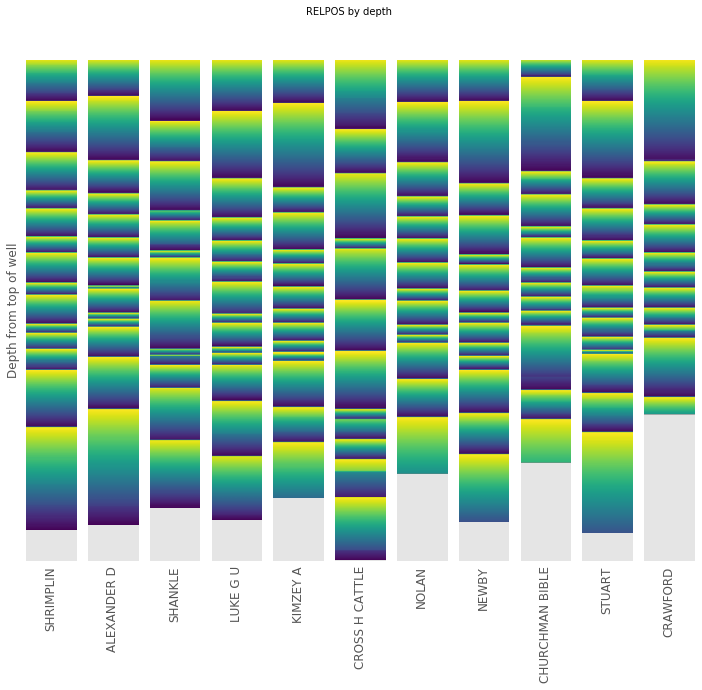

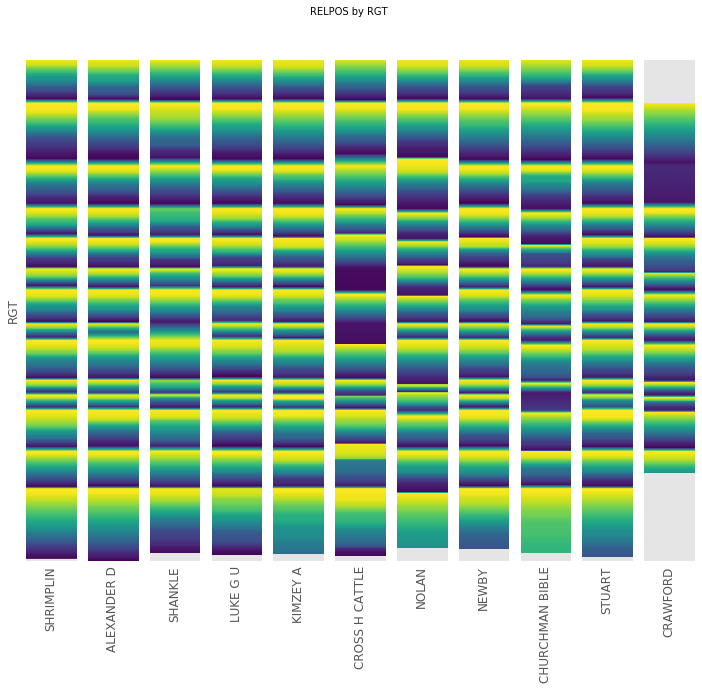

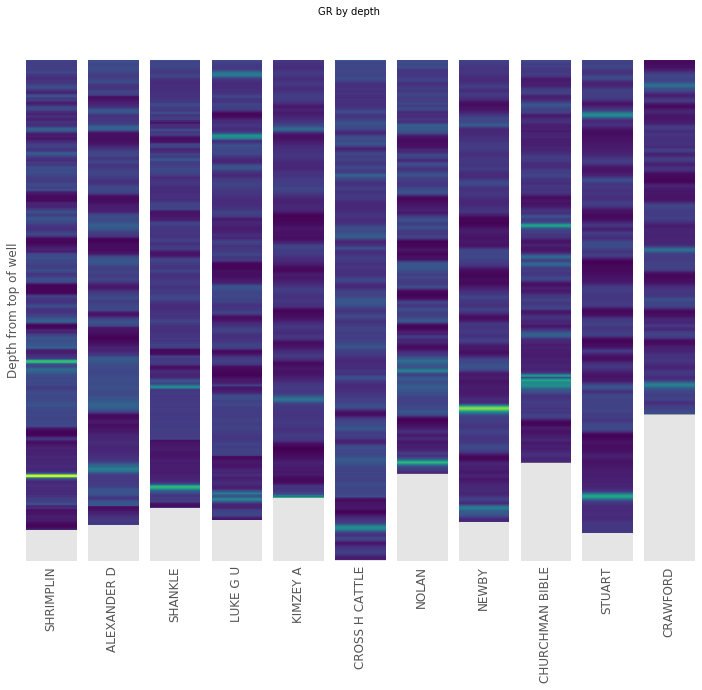

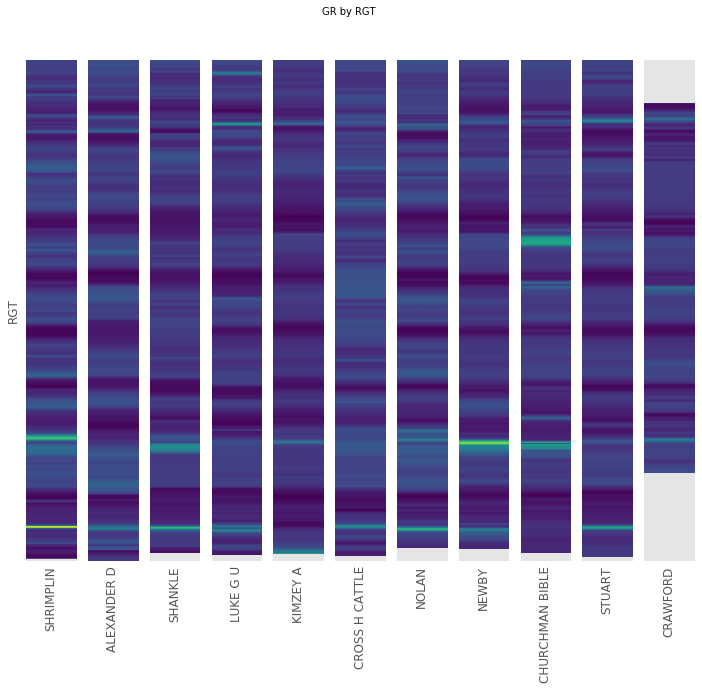

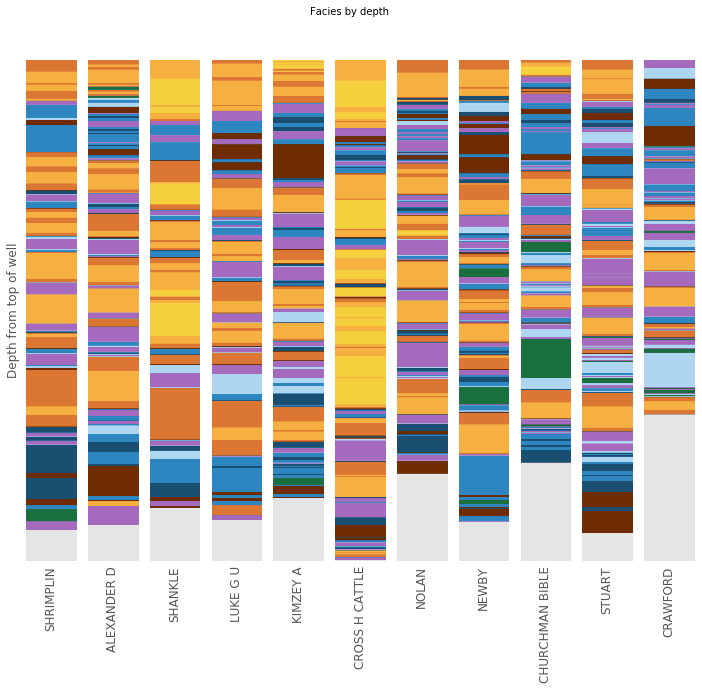

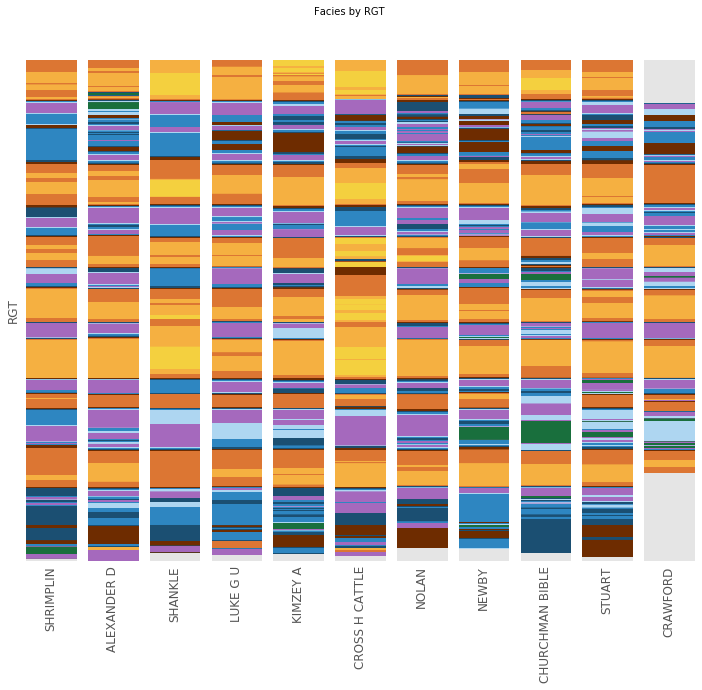

In [10]:
plotwellsim(data,'RELPOS',title='RELPOS by depth')
plotwellsim(data,'RELPOS','RGT',title='RELPOS by RGT')
plotwellsim(data,'GR',title='GR by depth')
plotwellsim(data,'GR','RGT',title='GR by RGT')
plotwellsim(data,'Facies',title='Facies by depth')
plotwellsim(data,'Facies','RGT',title='Facies by RGT')

I also used the dynamic warping distance to create another feature estimating the location of each well, by inverting for this using a least squares inversion. The results, shown below, do not appear to be very consistent with the Formation 3 Depth plot shown above. This may be due to inaccuracies in the approximation that the wells are in a line, or in the approximation that the formations are planar. The X1D values that I find are almost monotonic with the order of wells in the provided data.

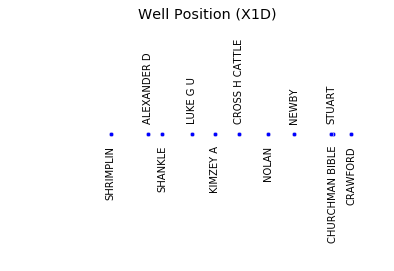

In [11]:
ax=plt.subplot(111)
plt.axis('off')
plt.ylim(-1,1)
plt.title('Well Position (X1D)')
for i,wellname in enumerate(get_wellnames(data)):
    x=data.loc[data['Well Name']==wellname, 'X1D'].values[0]
    plt.scatter(x=-x,y=0)
    if i%2==0:
        tva='top'
        ty=-0.1
    else:
        tva='bottom'
        ty=0.1
    plt.text(-x,ty,wellname,rotation='vertical',ha='center',va=tva)

The similarity of wells logs at the same RGT means that I can estimate the facies using a nearest neighbour estimator. The results are shown below, with the true facies for the training wells also shown for comparison.

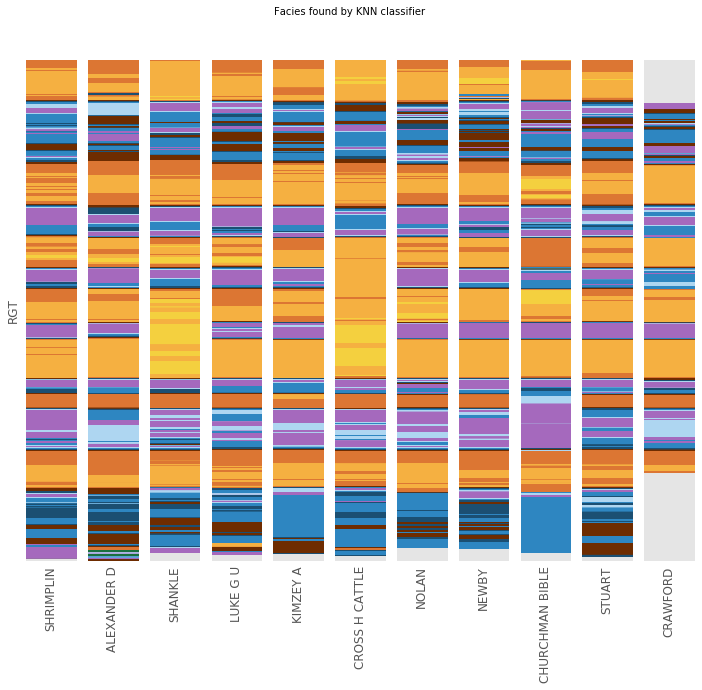

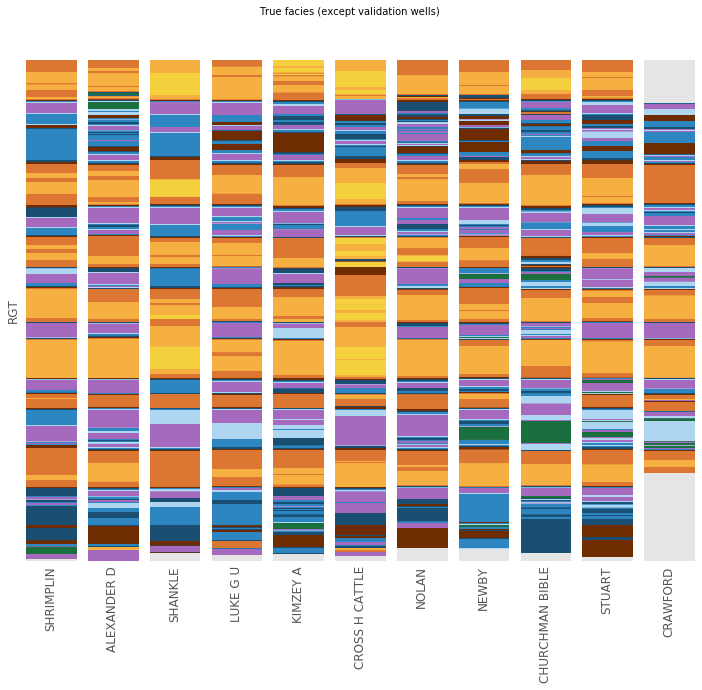

In [12]:
plotwellsim(data,'NeighbFacies','RGT','Facies found by KNN classifier')
plotwellsim(data,'Facies','RGT','True facies (except validation wells)')

I created what I refer to as 'interval' features. These capture information about the current interval, such as the distance from the beginning of it, size, and what fraction of the way through the interval the sample was taken. These features are made for the intervals of Formation, NM_M (non-marine/marine), and, when predicting PE, Facies. The features are calculated using the metrics Depth and RGT. Another interesting interval feature I created is compaction, which I calculate by dividing the size of the interval in RGT by its size in depth, capturing how much time has been compressed into that depth.

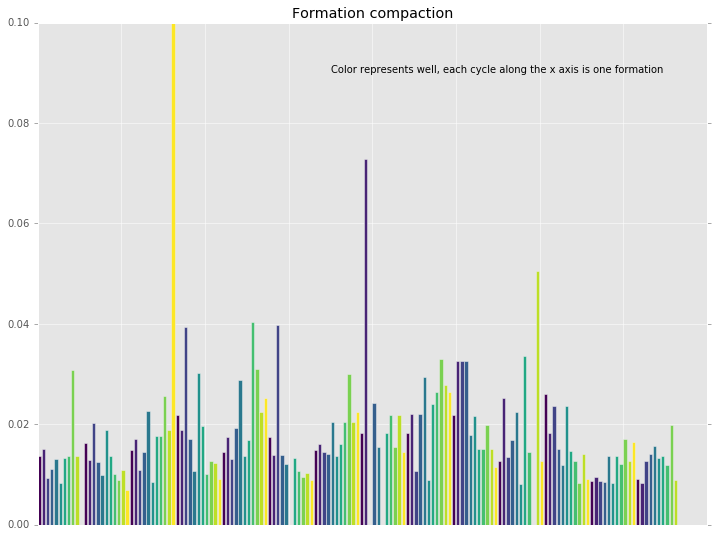

In [13]:
plt.figure(figsize=(12, 9))
plt.tick_params(axis="x", which="both", bottom="off", top="off", 
                labelbottom="off", left="off", right="off", labelleft="off")
wellnames = get_wellnames(data).tolist()
num_wells = get_numwells(data)
formations = data['FormationClass'].unique().tolist()
num_formations = len(formations)
colors=plt.cm.viridis(np.linspace(0,1,len(wellnames)))
dfg=data.groupby(['Well Name','FormationClass'], sort=False)
for i,(name,group) in enumerate(dfg):
    widx = wellnames.index(name[0])
    fidx = formations.index(name[1])
    plt.bar(fidx*num_wells+widx,group['FormationClassCompaction'].values[0],color=colors[widx])
plt.ylim(0,0.1)
plt.title('Formation compaction')
plt.text(70,0.09,'Color represents well, each cycle along the x axis is one formation')

My 'measurement' features consist of a median filter, derivative, and second derivative, of each type of log measurement. I also have a sharpened version of each measurement constructed by subtracting the second derivative from the measurement. The motivation for the sharpening filter is a crude attempt at deconvolving the smoothing effect of the measurement tools.

The final class of new features I introduce are 'interval measurement' features. These capture information about the well log measurements over an interval. The features are the mean, difference from the mean, standard deviation, and fraction of the standard deviation from the mean. A motivation for creating these features is the idea that the well log measurements may not be well calibrated between the wells, so using the raw values may not be very predictive. What fraction of the standard deviation over the interval the measurement is away from the mean over that interval, should be less affected by the calibration, however. The intervals I use are the Formation, the NM_M interval, each whole well, and a local Gaussian window around the sample depth.

## Prediction

Two of the training wells do not have PE measurement values. Scikit-Learn does not allow estimators to be created when the training data contains missing values. The missing PE values must thus be filled-in ("imputed") so that PE can be used in the facies prediction. A popular strategy for this is to use the mean or median. As well as its simplicity, this approach may be less susceptible to overfitting than another approach; using an estimator to predict the missing values. Despite the risk of overfitting, the estimator approach has the attraction of using all of the data, and so has the potential to yield more accurate results.

I perform the PE prediction using two steps. The first is to make an initial prediction of the facies values in the two validation wells using all of the data except the PE values. This allows all of the data, including that in the validation wells, to be used for the prediction of PE.

Once the PE data is complete, all of the data, now including PE, can be used for a second, and hopefully more accurate, prediction of the facies in the validation wells.

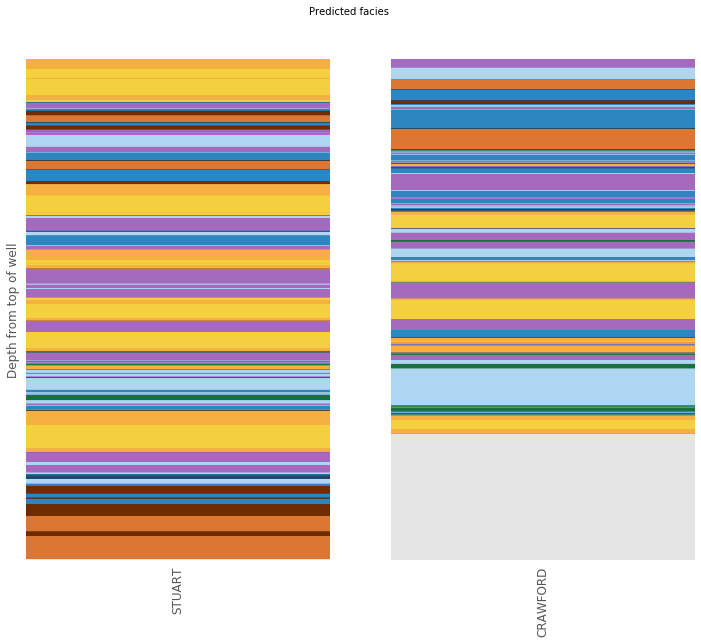

In [15]:
v_rows = (data['Well Name'] == 'STUART') | (data['Well Name'] == 'CRAWFORD')
plotwellsim(data.loc[v_rows,:],'Facies',title='Predicted facies')